# Forex Market Characterization Analysis

Analysis of EUR/USD and XAU/USD markets to determine:
1. Volatility by trading session (Asian, London, NY)
2. Market regime distribution (Trend vs Range)
3. Best times for Mean Reversion vs Momentum strategies
4. Multi-timeframe analysis insights

**Data source**: TypeScript analysis script (`forex-market-characterization.ts`)

In [14]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print('Libraries loaded successfully!')

Libraries loaded successfully!


## 1. Load Data

In [15]:
# Configuration - Change this to analyze different symbols
SYMBOL = 'frxEURUSD'  # Options: 'frxEURUSD', 'frxXAUUSD', 'frxGBPUSD'

# Load CSV files
try:
    detailed_df = pd.read_csv(f'{SYMBOL}_detailed_analysis.csv')
    session_df = pd.read_csv(f'{SYMBOL}_session_stats.csv')
    hourly_df = pd.read_csv(f'{SYMBOL}_hourly_stats.csv')
    day_df = pd.read_csv(f'{SYMBOL}_day_of_week_stats.csv')
    mr_df = pd.read_csv(f'{SYMBOL}_mean_reversion_stats.csv')
    print(f'Data loaded for {SYMBOL}')
    print(f'Total candles: {len(detailed_df)}')
except FileNotFoundError as e:
    print(f'Error: {e}')
    print('\nPlease run the TypeScript analysis first:')
    print('  SYMBOLS="frxEURUSD" DAYS=30 npx tsx src/scripts/forex-market-characterization.ts')

Data loaded for frxEURUSD
Total candles: 4951


In [16]:
# Convert timestamp to datetime
detailed_df['datetime'] = pd.to_datetime(detailed_df['timestamp'], unit='s')
detailed_df['date'] = detailed_df['datetime'].dt.date

# Preview data
print('Sample data:')
detailed_df.head()

Sample data:


,timestamp,dateUTC,hourUTC,dayOfWeek,session,price,atr,atrPercent,range,rangePercent,bbWidth,bbWidthPercent,adx,regime,rsi,ema8,ema21,ema50,trendStrength,bbUpper,bbLower,bbMiddle,distanceFromBBMiddle,distanceFromBBMiddlePercent,pricePosition,datetime,date
0,1763946540,2025-11-24T01:09:00.000Z,1,Monday,ASIAN,1.15076,0.000059,0.0051,0.00001,0.0009,0.000418,0.0363,28.01,TREND_UP,59.18,1.150743,1.150689,1.150588,1.0,1.150891,1.150472,1.150682,0.000078,0.0068,MIDDLE,2025-11-24 01:09:00,2025-11-24
1,1763946600,2025-11-24T01:10:00.000Z,1,Monday,ASIAN,1.15076,0.000057,0.0049,0.00003,0.0026,0.000410,0.0357,28.21,TREND_UP,59.18,1.150747,1.150696,1.150594,1.0,1.150896,1.150486,1.150691,0.000069,0.0060,MIDDLE,2025-11-24 01:10:00,2025-11-24
2,1763946660,2025-11-24T01:11:00.000Z,1,Monday,ASIAN,1.15076,0.000054,0.0047,0.00002,0.0017,0.000396,0.0344,28.22,TREND_UP,59.18,1.150750,1.150702,1.150601,1.0,1.150899,1.150503,1.150701,0.000059,0.0051,MIDDLE,2025-11-24 01:11:00,2025-11-24
3,1763946720,2025-11-24T01:12:00.000Z,1,Monday,ASIAN,1.15068,0.000056,0.0049,0.00008,0.0070,0.000368,0.0320,27.00,RANGE_VOLATILE,50.54,1.150734,1.150700,1.150604,0.5,1.150892,1.150524,1.150708,-0.000028,-0.0024,MIDDLE,2025-11-24 01:12:00,2025-11-24
4,1763946780,2025-11-24T01:13:00.000Z,1,Monday,ASIAN,1.15066,0.000055,0.0048,0.00004,0.0035,0.000329,0.0286,25.56,RANGE_VOLATILE,48.63,1.150718,1.150696,1.150606,0.5,1.150880,1.150550,1.150715,-0.000055,-0.0048,MIDDLE,2025-11-24 01:13:00,2025-11-24


## 2. Volatility Analysis by Session

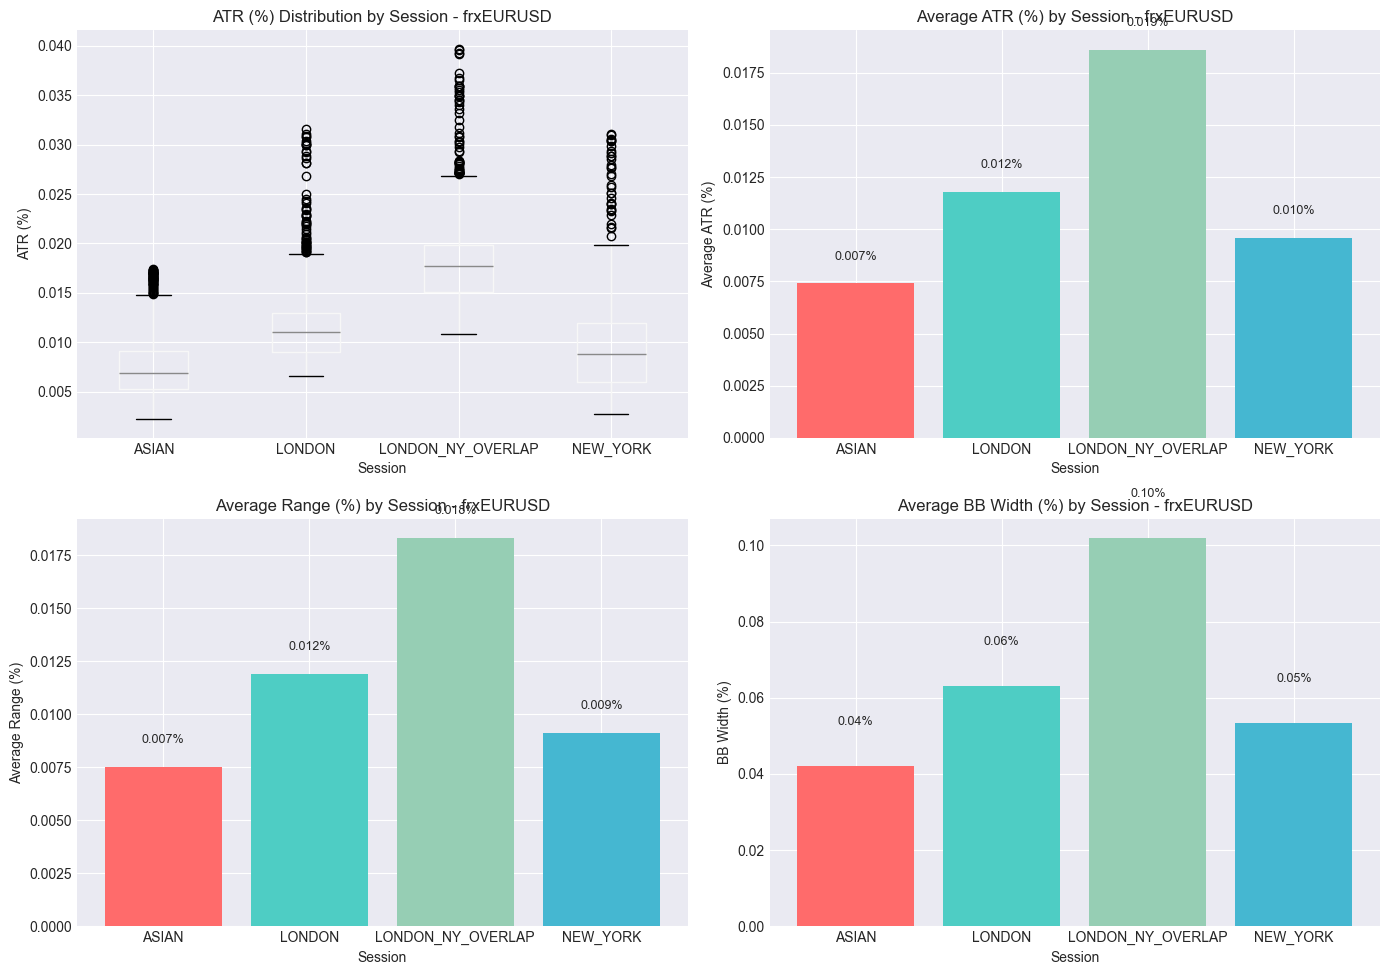


VOLATILITY SUMMARY
                   avgATRPercent  avgRangePercent  avgBBWidth
session                                                      
ASIAN                     0.0074           0.0075      0.0421
LONDON                    0.0118           0.0119      0.0630
LONDON_NY_OVERLAP         0.0186           0.0183      0.1018
NEW_YORK                  0.0096           0.0091      0.0534


In [17]:
# Session colors
session_colors = {
    'ASIAN': '#FF6B6B',
    'LONDON': '#4ECDC4',
    'NEW_YORK': '#45B7D1',
    'LONDON_NY_OVERLAP': '#96CEB4'
}

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. ATR by Session (Boxplot)
ax1 = axes[0, 0]
session_order = ['ASIAN', 'LONDON', 'LONDON_NY_OVERLAP', 'NEW_YORK']
colors = [session_colors[s] for s in session_order]
bp = detailed_df.boxplot(column='atrPercent', by='session', ax=ax1, 
                          positions=[session_order.index(s) for s in detailed_df['session'].unique()])
ax1.set_title(f'ATR (%) Distribution by Session - {SYMBOL}')
ax1.set_xlabel('Session')
ax1.set_ylabel('ATR (%)')
ax1.set_xticklabels(session_order)
plt.suptitle('')

# 2. Average ATR by Session (Bar)
ax2 = axes[0, 1]
session_df_sorted = session_df.set_index('session').reindex(session_order)
bars = ax2.bar(session_df_sorted.index, session_df_sorted['avgATRPercent'], 
               color=[session_colors[s] for s in session_df_sorted.index])
ax2.set_title(f'Average ATR (%) by Session - {SYMBOL}')
ax2.set_xlabel('Session')
ax2.set_ylabel('Average ATR (%)')
for bar, val in zip(bars, session_df_sorted['avgATRPercent']):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
             f'{val:.3f}%', ha='center', va='bottom', fontsize=9)

# 3. Range (High-Low) by Session
ax3 = axes[1, 0]
bars = ax3.bar(session_df_sorted.index, session_df_sorted['avgRangePercent'], 
               color=[session_colors[s] for s in session_df_sorted.index])
ax3.set_title(f'Average Range (%) by Session - {SYMBOL}')
ax3.set_xlabel('Session')
ax3.set_ylabel('Average Range (%)')
for bar, val in zip(bars, session_df_sorted['avgRangePercent']):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
             f'{val:.3f}%', ha='center', va='bottom', fontsize=9)

# 4. BB Width by Session
ax4 = axes[1, 1]
bars = ax4.bar(session_df_sorted.index, session_df_sorted['avgBBWidth'], 
               color=[session_colors[s] for s in session_df_sorted.index])
ax4.set_title(f'Average BB Width (%) by Session - {SYMBOL}')
ax4.set_xlabel('Session')
ax4.set_ylabel('BB Width (%)')
for bar, val in zip(bars, session_df_sorted['avgBBWidth']):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{val:.2f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(f'{SYMBOL}_volatility_by_session.png', dpi=150, bbox_inches='tight')
plt.show()

print('\n' + '='*60)
print('VOLATILITY SUMMARY')
print('='*60)
print(session_df_sorted[['avgATRPercent', 'avgRangePercent', 'avgBBWidth']].to_string())

## 3. Market Regime Analysis (Trend vs Range)

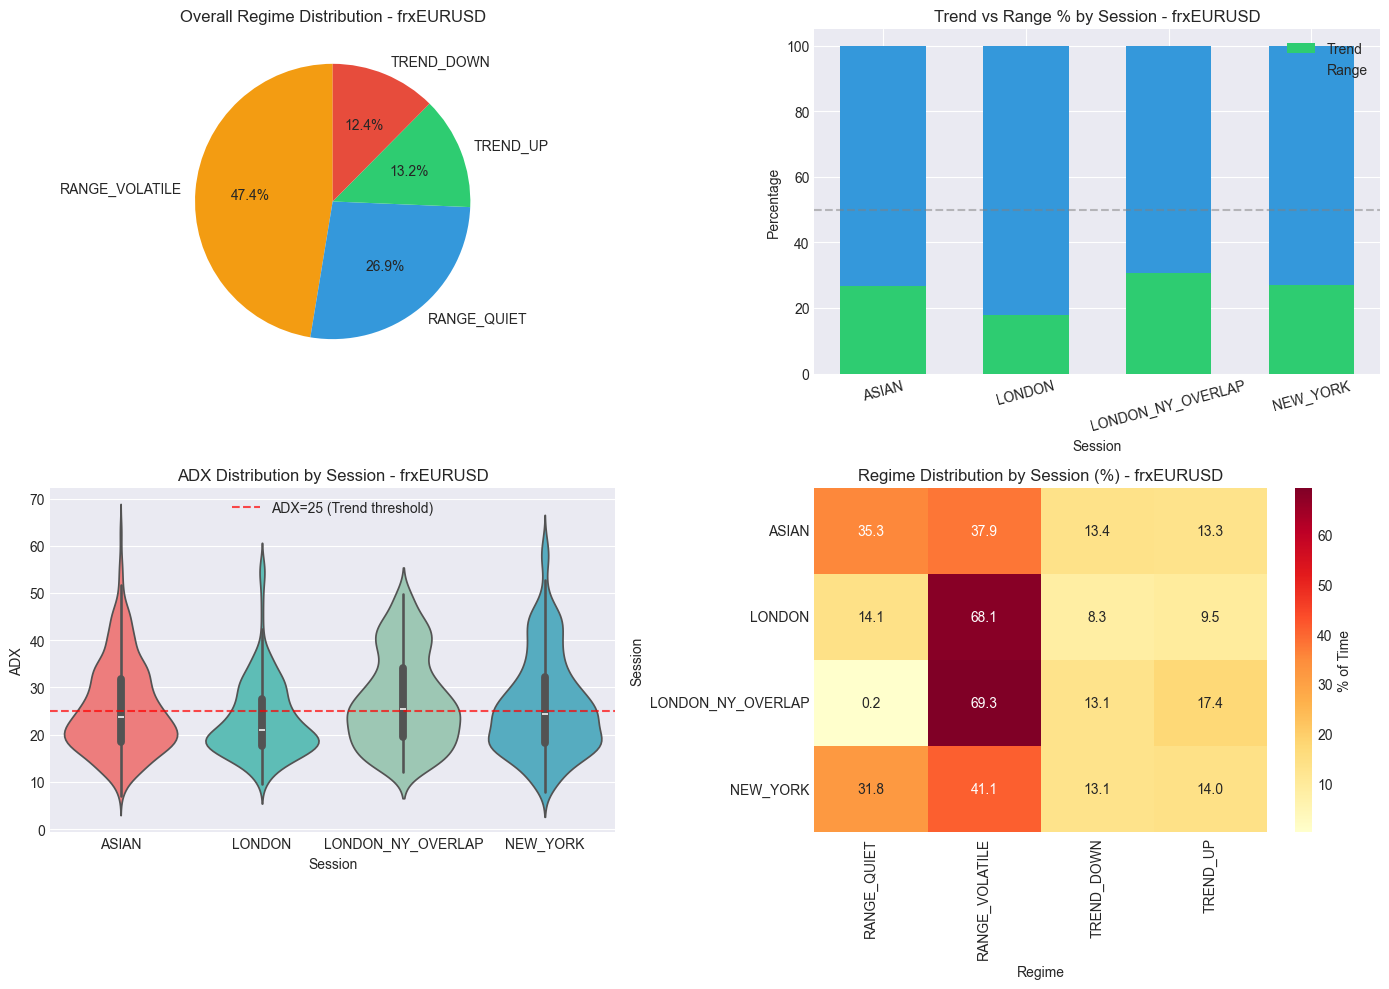


REGIME SUMMARY BY SESSION
                   trendPercent  rangePercent  avgADX
session                                              
ASIAN                     26.72         73.28   25.69
LONDON                    17.84         82.16   23.20
LONDON_NY_OVERLAP         30.56         69.44   27.26
NEW_YORK                  27.13         72.87   26.26


In [18]:
# Regime colors
regime_colors = {
    'TREND_UP': '#2ECC71',
    'TREND_DOWN': '#E74C3C',
    'RANGE_QUIET': '#3498DB',
    'RANGE_VOLATILE': '#F39C12',
    'UNCERTAIN': '#95A5A6'
}

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Overall Regime Distribution (Pie)
ax1 = axes[0, 0]
regime_counts = detailed_df['regime'].value_counts()
colors = [regime_colors.get(r, '#999') for r in regime_counts.index]
ax1.pie(regime_counts.values, labels=regime_counts.index, colors=colors,
        autopct='%1.1f%%', startangle=90)
ax1.set_title(f'Overall Regime Distribution - {SYMBOL}')

# 2. Trend vs Range by Session (Stacked Bar)
ax2 = axes[0, 1]
session_df_sorted = session_df.set_index('session').reindex(session_order)
x = np.arange(len(session_order))
width = 0.6
ax2.bar(x, session_df_sorted['trendPercent'], width, label='Trend', color='#2ECC71')
ax2.bar(x, session_df_sorted['rangePercent'], width, bottom=session_df_sorted['trendPercent'], 
        label='Range', color='#3498DB')
ax2.set_title(f'Trend vs Range % by Session - {SYMBOL}')
ax2.set_xlabel('Session')
ax2.set_ylabel('Percentage')
ax2.set_xticks(x)
ax2.set_xticklabels(session_order, rotation=15)
ax2.legend()
ax2.axhline(y=50, color='gray', linestyle='--', alpha=0.5)

# 3. ADX Distribution by Session (Violin)
ax3 = axes[1, 0]
sns.violinplot(data=detailed_df, x='session', y='adx', ax=ax3, order=session_order,
               palette=[session_colors[s] for s in session_order])
ax3.axhline(y=25, color='red', linestyle='--', alpha=0.7, label='ADX=25 (Trend threshold)')
ax3.set_title(f'ADX Distribution by Session - {SYMBOL}')
ax3.set_xlabel('Session')
ax3.set_ylabel('ADX')
ax3.legend()

# 4. Regime by Session (Heatmap)
ax4 = axes[1, 1]
regime_by_session = detailed_df.groupby(['session', 'regime']).size().unstack(fill_value=0)
regime_by_session_pct = regime_by_session.div(regime_by_session.sum(axis=1), axis=0) * 100
regime_by_session_pct = regime_by_session_pct.reindex(session_order)
sns.heatmap(regime_by_session_pct, annot=True, fmt='.1f', cmap='YlOrRd', ax=ax4,
            cbar_kws={'label': '% of Time'})
ax4.set_title(f'Regime Distribution by Session (%) - {SYMBOL}')
ax4.set_xlabel('Regime')
ax4.set_ylabel('Session')

plt.tight_layout()
plt.savefig(f'{SYMBOL}_regime_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print('\n' + '='*60)
print('REGIME SUMMARY BY SESSION')
print('='*60)
print(session_df_sorted[['trendPercent', 'rangePercent', 'avgADX']].to_string())

## 4. Hourly Analysis (Heatmap)

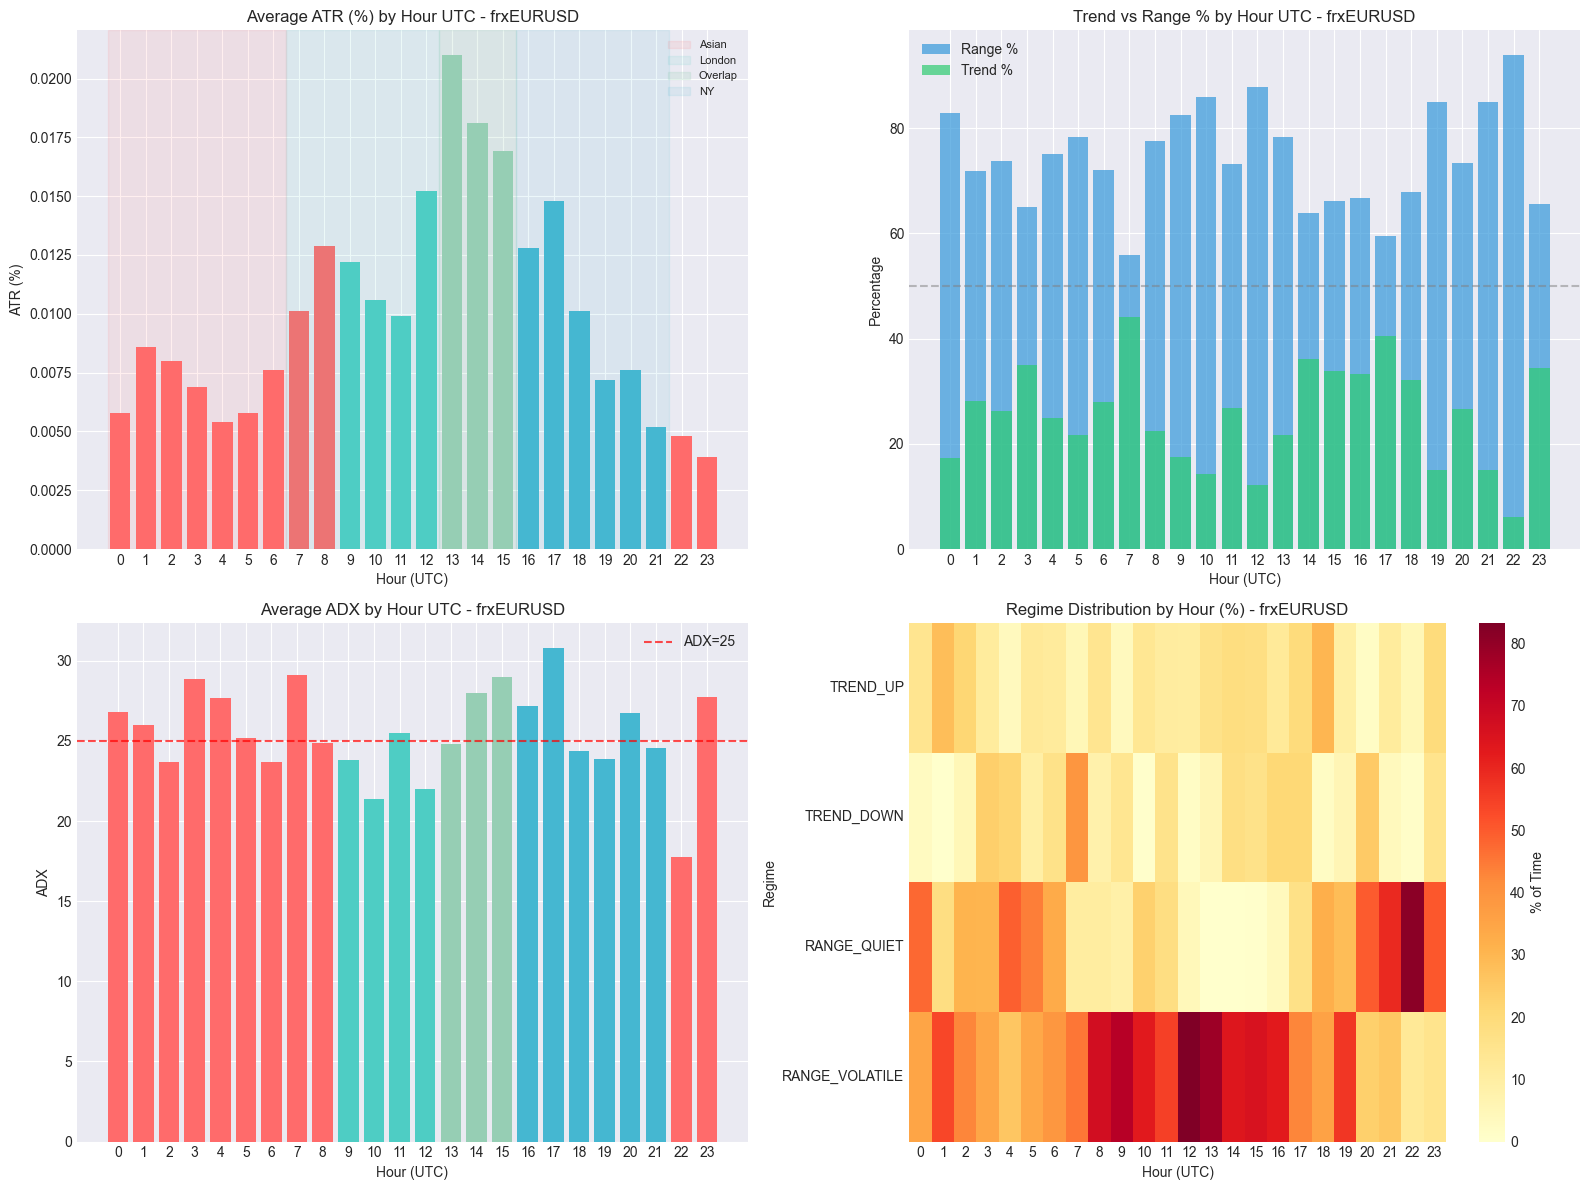


BEST HOURS FOR EACH STRATEGY

Best hours for MEAN REVERSION (high range %):
 hour  session  rangePercent
   22    ASIAN         93.89
   12   LONDON         87.78
   10   LONDON         85.83
   19 NEW_YORK         85.00
   21 NEW_YORK         85.00

Best hours for MOMENTUM/TREND (high trend %):
 hour           session  trendPercent
    7             ASIAN         44.17
   17          NEW_YORK         40.56
   14 LONDON_NY_OVERLAP         36.11
    3             ASIAN         35.00
   23             ASIAN         34.44


In [19]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Prepare hourly data
hourly_df_sorted = hourly_df.sort_values('hour')

# 1. ATR% by Hour
ax1 = axes[0, 0]
colors = [session_colors.get(s, '#999') for s in hourly_df_sorted['session']]
bars = ax1.bar(hourly_df_sorted['hour'], hourly_df_sorted['avgATRPercent'], color=colors)
ax1.set_title(f'Average ATR (%) by Hour UTC - {SYMBOL}')
ax1.set_xlabel('Hour (UTC)')
ax1.set_ylabel('ATR (%)')
ax1.set_xticks(range(24))

# Add session labels
ax1.axvspan(-0.5, 6.5, alpha=0.1, color=session_colors['ASIAN'], label='Asian')
ax1.axvspan(6.5, 12.5, alpha=0.1, color=session_colors['LONDON'], label='London')
ax1.axvspan(12.5, 15.5, alpha=0.2, color=session_colors['LONDON_NY_OVERLAP'], label='Overlap')
ax1.axvspan(15.5, 21.5, alpha=0.1, color=session_colors['NEW_YORK'], label='NY')
ax1.legend(loc='upper right', fontsize=8)

# 2. Range% by Hour
ax2 = axes[0, 1]
ax2.bar(hourly_df_sorted['hour'], hourly_df_sorted['rangePercent'], 
        color='#3498DB', alpha=0.7, label='Range %')
ax2.bar(hourly_df_sorted['hour'], hourly_df_sorted['trendPercent'], 
        color='#2ECC71', alpha=0.7, label='Trend %')
ax2.set_title(f'Trend vs Range % by Hour UTC - {SYMBOL}')
ax2.set_xlabel('Hour (UTC)')
ax2.set_ylabel('Percentage')
ax2.set_xticks(range(24))
ax2.legend()
ax2.axhline(y=50, color='gray', linestyle='--', alpha=0.5)

# 3. ADX by Hour
ax3 = axes[1, 0]
ax3.bar(hourly_df_sorted['hour'], hourly_df_sorted['avgADX'], color=colors)
ax3.axhline(y=25, color='red', linestyle='--', alpha=0.7, label='ADX=25')
ax3.set_title(f'Average ADX by Hour UTC - {SYMBOL}')
ax3.set_xlabel('Hour (UTC)')
ax3.set_ylabel('ADX')
ax3.set_xticks(range(24))
ax3.legend()

# 4. Regime Heatmap by Hour
ax4 = axes[1, 1]
hourly_regime = hourly_df_sorted.set_index('hour')[['TREND_UP', 'TREND_DOWN', 'RANGE_QUIET', 'RANGE_VOLATILE']]
hourly_regime_pct = hourly_regime.div(hourly_regime.sum(axis=1), axis=0) * 100
sns.heatmap(hourly_regime_pct.T, annot=False, cmap='YlOrRd', ax=ax4,
            cbar_kws={'label': '% of Time'})
ax4.set_title(f'Regime Distribution by Hour (%) - {SYMBOL}')
ax4.set_xlabel('Hour (UTC)')
ax4.set_ylabel('Regime')

plt.tight_layout()
plt.savefig(f'{SYMBOL}_hourly_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# Best hours for each strategy
print('\n' + '='*60)
print('BEST HOURS FOR EACH STRATEGY')
print('='*60)

best_range_hours = hourly_df_sorted.nlargest(5, 'rangePercent')[['hour', 'session', 'rangePercent']]
best_trend_hours = hourly_df_sorted.nlargest(5, 'trendPercent')[['hour', 'session', 'trendPercent']]

print('\nBest hours for MEAN REVERSION (high range %):')
print(best_range_hours.to_string(index=False))

print('\nBest hours for MOMENTUM/TREND (high trend %):')
print(best_trend_hours.to_string(index=False))

## 5. Day of Week Analysis

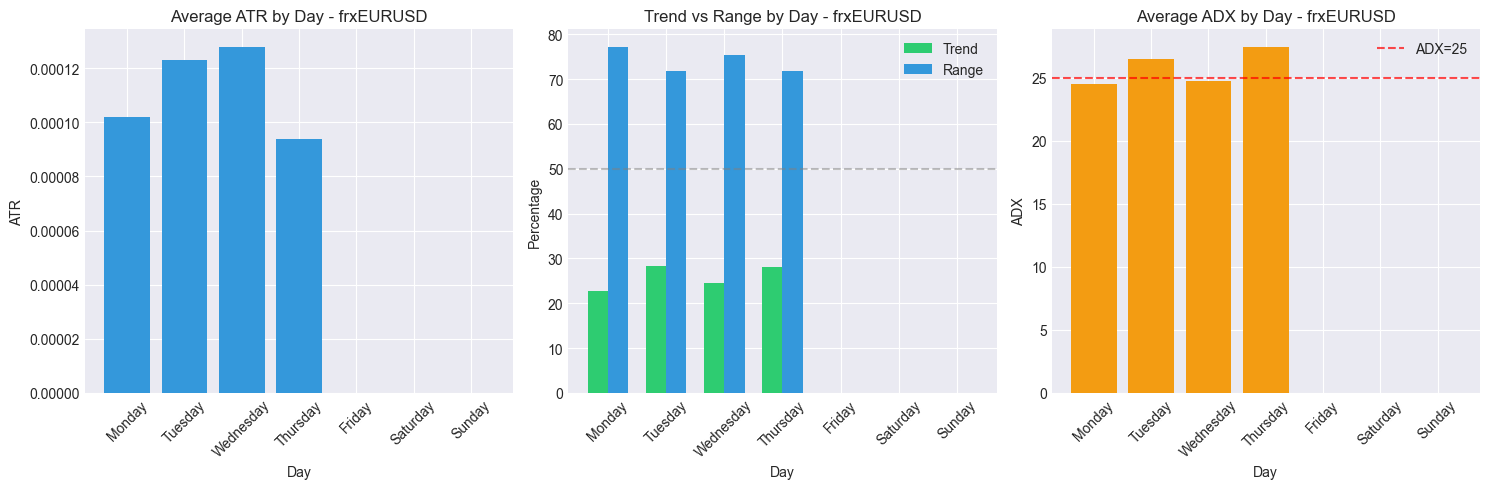


DAY OF WEEK SUMMARY
      day  count   avgATR  avgADX  trendPercent  rangePercent
   Monday   1371 0.000102   24.47         22.76         77.24
  Tuesday   1440 0.000123   26.45         28.26         71.74
Wednesday   1440 0.000128   24.73         24.58         75.42
 Thursday    700 0.000094   27.45         28.14         71.86
   Friday      0 0.000000    0.00          0.00          0.00
 Saturday      0 0.000000    0.00          0.00          0.00
   Sunday      0 0.000000    0.00          0.00          0.00


In [20]:
# Order days properly
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_df['day'] = pd.Categorical(day_df['day'], categories=day_order, ordered=True)
day_df_sorted = day_df.sort_values('day')

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 1. ATR by Day
ax1 = axes[0]
ax1.bar(day_df_sorted['day'], day_df_sorted['avgATR'], color='#3498DB')
ax1.set_title(f'Average ATR by Day - {SYMBOL}')
ax1.set_xlabel('Day')
ax1.set_ylabel('ATR')
ax1.tick_params(axis='x', rotation=45)

# 2. Trend vs Range by Day
ax2 = axes[1]
x = np.arange(len(day_df_sorted))
width = 0.35
ax2.bar(x - width/2, day_df_sorted['trendPercent'], width, label='Trend', color='#2ECC71')
ax2.bar(x + width/2, day_df_sorted['rangePercent'], width, label='Range', color='#3498DB')
ax2.set_title(f'Trend vs Range by Day - {SYMBOL}')
ax2.set_xlabel('Day')
ax2.set_ylabel('Percentage')
ax2.set_xticks(x)
ax2.set_xticklabels(day_df_sorted['day'], rotation=45)
ax2.legend()
ax2.axhline(y=50, color='gray', linestyle='--', alpha=0.5)

# 3. ADX by Day
ax3 = axes[2]
ax3.bar(day_df_sorted['day'], day_df_sorted['avgADX'], color='#F39C12')
ax3.axhline(y=25, color='red', linestyle='--', alpha=0.7, label='ADX=25')
ax3.set_title(f'Average ADX by Day - {SYMBOL}')
ax3.set_xlabel('Day')
ax3.set_ylabel('ADX')
ax3.tick_params(axis='x', rotation=45)
ax3.legend()

plt.tight_layout()
plt.savefig(f'{SYMBOL}_day_of_week_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print('\n' + '='*60)
print('DAY OF WEEK SUMMARY')
print('='*60)
print(day_df_sorted.to_string(index=False))

## 6. Mean Reversion Analysis

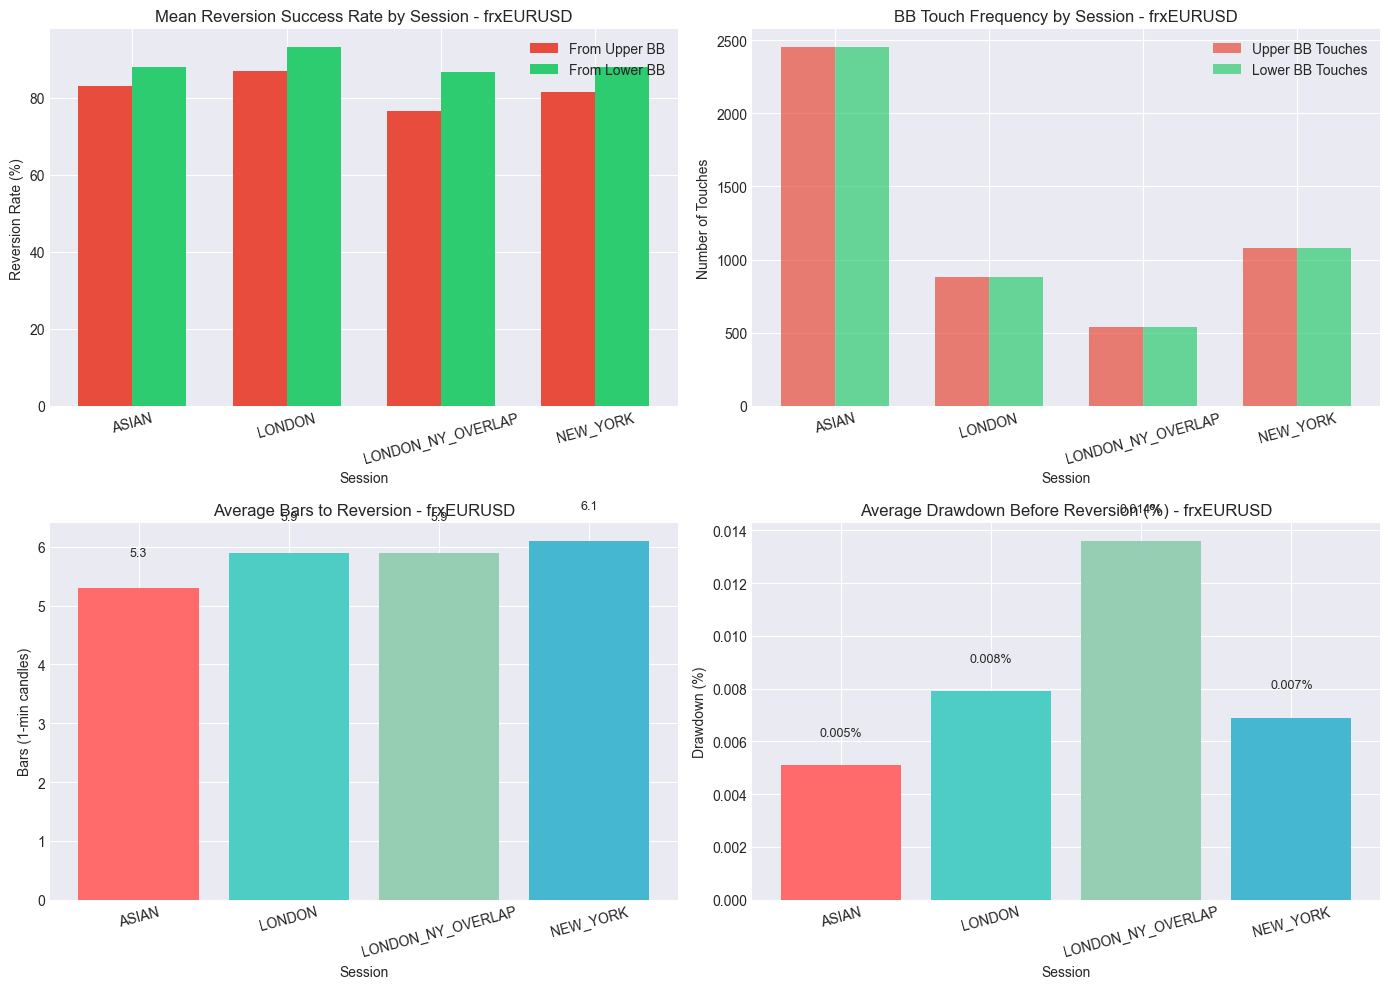


MEAN REVERSION SUMMARY
          session  totalTouchesUpper  totalTouchesLower  reversionsFromUpper  reversionsFromLower  reversionRateUpper  reversionRateLower  avgBarsToReversion  avgDrawdownBeforeReversion
            ASIAN               2451               2451                 2036                 2156               83.07               87.96                 5.3                      0.0051
           LONDON                880                880                  764                  819               86.82               93.07                 5.9                      0.0079
         NEW_YORK               1080               1080                  880                  950               81.48               87.96                 6.1                      0.0069
LONDON_NY_OVERLAP                540                540                  414                  468               76.67               86.67                 5.9                      0.0136


In [21]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

mr_df_sorted = mr_df.set_index('session').reindex(session_order)

# 1. Reversion Rate by Session
ax1 = axes[0, 0]
x = np.arange(len(session_order))
width = 0.35
ax1.bar(x - width/2, mr_df_sorted['reversionRateUpper'], width, 
        label='From Upper BB', color='#E74C3C')
ax1.bar(x + width/2, mr_df_sorted['reversionRateLower'], width, 
        label='From Lower BB', color='#2ECC71')
ax1.set_title(f'Mean Reversion Success Rate by Session - {SYMBOL}')
ax1.set_xlabel('Session')
ax1.set_ylabel('Reversion Rate (%)')
ax1.set_xticks(x)
ax1.set_xticklabels(session_order, rotation=15)
ax1.legend()

# 2. BB Touches by Session
ax2 = axes[0, 1]
ax2.bar(x - width/2, mr_df_sorted['totalTouchesUpper'], width, 
        label='Upper BB Touches', color='#E74C3C', alpha=0.7)
ax2.bar(x + width/2, mr_df_sorted['totalTouchesLower'], width, 
        label='Lower BB Touches', color='#2ECC71', alpha=0.7)
ax2.set_title(f'BB Touch Frequency by Session - {SYMBOL}')
ax2.set_xlabel('Session')
ax2.set_ylabel('Number of Touches')
ax2.set_xticks(x)
ax2.set_xticklabels(session_order, rotation=15)
ax2.legend()

# 3. Avg Bars to Reversion
ax3 = axes[1, 0]
colors = [session_colors[s] for s in mr_df_sorted.index]
bars = ax3.bar(mr_df_sorted.index, mr_df_sorted['avgBarsToReversion'], color=colors)
ax3.set_title(f'Average Bars to Reversion - {SYMBOL}')
ax3.set_xlabel('Session')
ax3.set_ylabel('Bars (1-min candles)')
ax3.tick_params(axis='x', rotation=15)
for bar, val in zip(bars, mr_df_sorted['avgBarsToReversion']):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{val:.1f}', ha='center', va='bottom', fontsize=9)

# 4. Avg Drawdown Before Reversion
ax4 = axes[1, 1]
bars = ax4.bar(mr_df_sorted.index, mr_df_sorted['avgDrawdownBeforeReversion'], color=colors)
ax4.set_title(f'Average Drawdown Before Reversion (%) - {SYMBOL}')
ax4.set_xlabel('Session')
ax4.set_ylabel('Drawdown (%)')
ax4.tick_params(axis='x', rotation=15)
for bar, val in zip(bars, mr_df_sorted['avgDrawdownBeforeReversion']):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
             f'{val:.3f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(f'{SYMBOL}_mean_reversion_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print('\n' + '='*60)
print('MEAN REVERSION SUMMARY')
print('='*60)
print(mr_df.to_string(index=False))

## 7. Price Position Analysis (Upper/Middle/Lower BB)

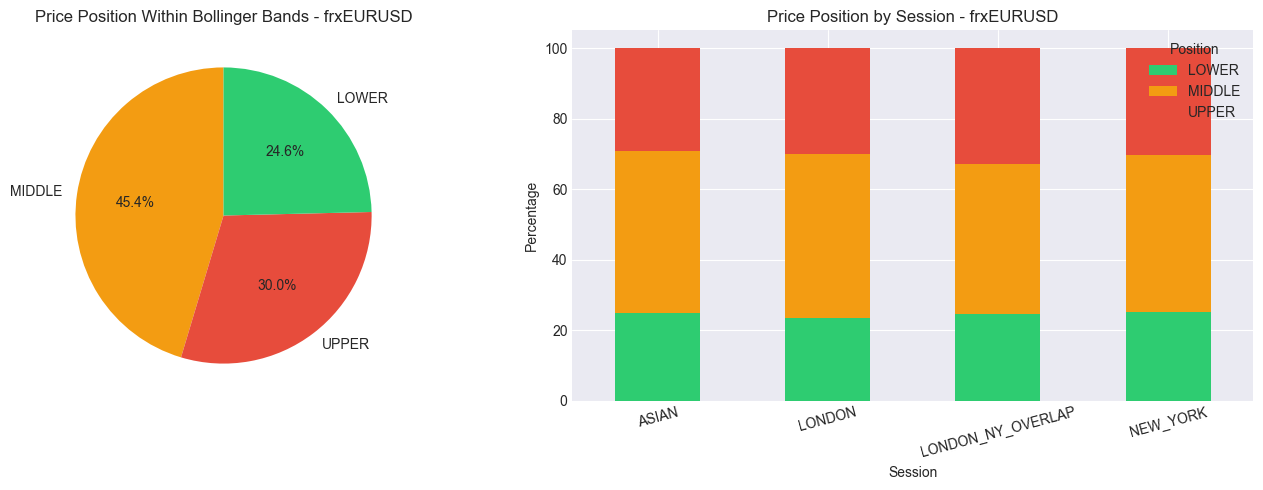

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Price Position Distribution
ax1 = axes[0]
position_counts = detailed_df['pricePosition'].value_counts()
position_colors = {'UPPER': '#E74C3C', 'MIDDLE': '#F39C12', 'LOWER': '#2ECC71'}
colors = [position_colors.get(p, '#999') for p in position_counts.index]
ax1.pie(position_counts.values, labels=position_counts.index, colors=colors,
        autopct='%1.1f%%', startangle=90)
ax1.set_title(f'Price Position Within Bollinger Bands - {SYMBOL}')

# 2. Price Position by Session
ax2 = axes[1]
position_by_session = detailed_df.groupby(['session', 'pricePosition']).size().unstack(fill_value=0)
position_by_session_pct = position_by_session.div(position_by_session.sum(axis=1), axis=0) * 100
position_by_session_pct = position_by_session_pct.reindex(session_order)
position_by_session_pct.plot(kind='bar', stacked=True, ax=ax2, 
                              color=[position_colors.get(c, '#999') for c in position_by_session_pct.columns])
ax2.set_title(f'Price Position by Session - {SYMBOL}')
ax2.set_xlabel('Session')
ax2.set_ylabel('Percentage')
ax2.legend(title='Position')
ax2.tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.savefig(f'{SYMBOL}_price_position_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Autocorrelation Analysis

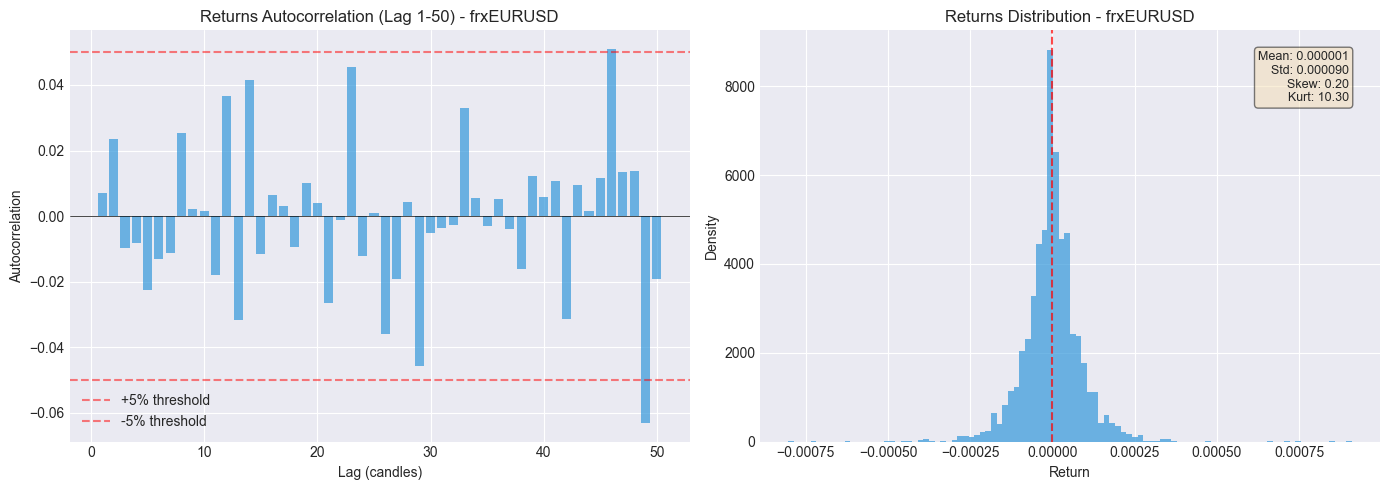


AUTOCORRELATION ANALYSIS
Lag-1 Autocorrelation: 0.006923
Lag-5 Autocorrelation: -0.022681
Lag-10 Autocorrelation: 0.001634

Weak autocorrelation - Both strategies may work similarly


In [23]:
# Calculate returns
detailed_df['returns'] = detailed_df['price'].pct_change()

# Calculate autocorrelation for different lags
max_lag = 50
autocorr = [detailed_df['returns'].autocorr(lag=i) for i in range(1, max_lag + 1)]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Autocorrelation Plot
ax1 = axes[0]
ax1.bar(range(1, max_lag + 1), autocorr, color='#3498DB', alpha=0.7)
ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax1.axhline(y=0.05, color='red', linestyle='--', alpha=0.5, label='+5% threshold')
ax1.axhline(y=-0.05, color='red', linestyle='--', alpha=0.5, label='-5% threshold')
ax1.set_title(f'Returns Autocorrelation (Lag 1-{max_lag}) - {SYMBOL}')
ax1.set_xlabel('Lag (candles)')
ax1.set_ylabel('Autocorrelation')
ax1.legend()

# 2. Returns Distribution
ax2 = axes[1]
ax2.hist(detailed_df['returns'].dropna(), bins=100, density=True, alpha=0.7, color='#3498DB')
ax2.set_title(f'Returns Distribution - {SYMBOL}')
ax2.set_xlabel('Return')
ax2.set_ylabel('Density')
ax2.axvline(x=0, color='red', linestyle='--', alpha=0.7)

# Add statistics
mean_return = detailed_df['returns'].mean()
std_return = detailed_df['returns'].std()
skewness = detailed_df['returns'].skew()
kurtosis = detailed_df['returns'].kurtosis()

stats_text = f'Mean: {mean_return:.6f}\nStd: {std_return:.6f}\nSkew: {skewness:.2f}\nKurt: {kurtosis:.2f}'
ax2.text(0.95, 0.95, stats_text, transform=ax2.transAxes, fontsize=9,
         verticalalignment='top', horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig(f'{SYMBOL}_autocorrelation_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print('\n' + '='*60)
print('AUTOCORRELATION ANALYSIS')
print('='*60)
print(f'Lag-1 Autocorrelation: {autocorr[0]:.6f}')
print(f'Lag-5 Autocorrelation: {autocorr[4]:.6f}')
print(f'Lag-10 Autocorrelation: {autocorr[9]:.6f}')
print()
if autocorr[0] < -0.03:
    print('Negative autocorrelation detected - MEAN REVERSION is viable!')
elif autocorr[0] > 0.03:
    print('Positive autocorrelation detected - MOMENTUM/TREND is viable!')
else:
    print('Weak autocorrelation - Both strategies may work similarly')

## 9. Time-based Heatmap (Day x Hour)

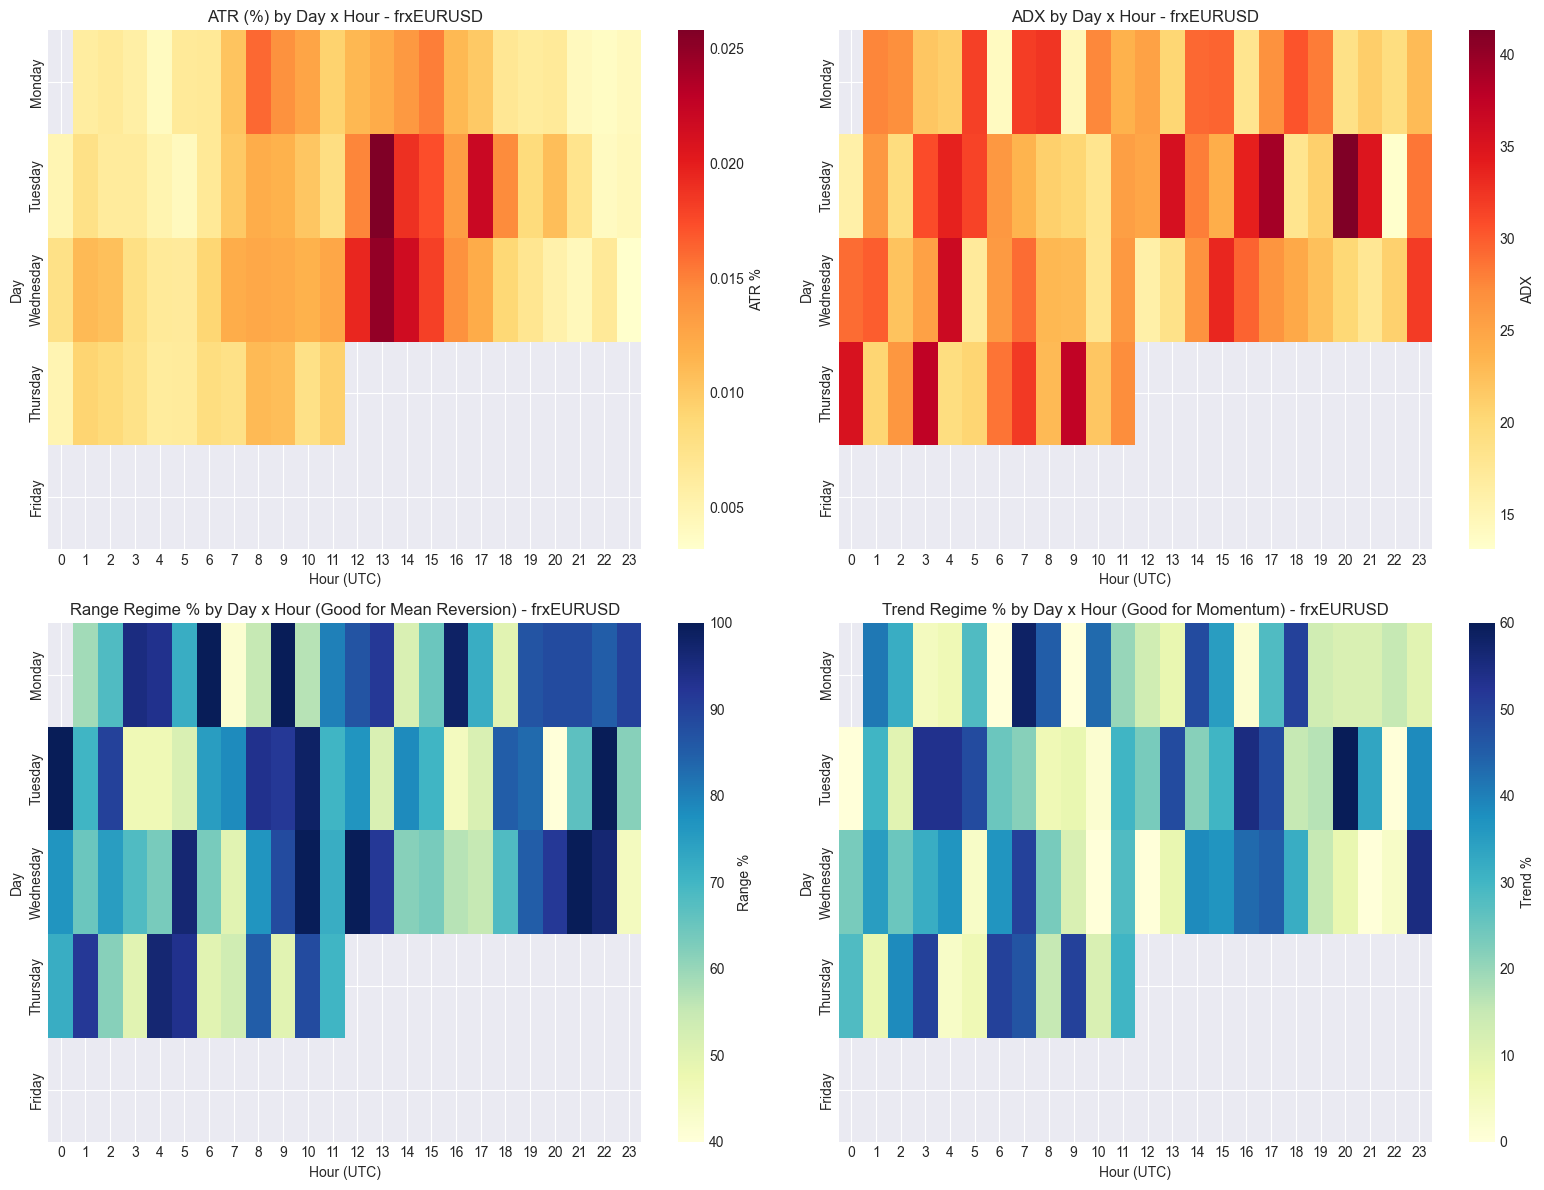

In [24]:
# Create day x hour pivot tables
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
filtered_df = detailed_df[detailed_df['dayOfWeek'].isin(day_order)]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. ATR% Heatmap
ax1 = axes[0, 0]
pivot_atr = filtered_df.pivot_table(values='atrPercent', index='dayOfWeek', columns='hourUTC', aggfunc='mean')
pivot_atr = pivot_atr.reindex(day_order)
sns.heatmap(pivot_atr, cmap='YlOrRd', ax=ax1, annot=False, cbar_kws={'label': 'ATR %'})
ax1.set_title(f'ATR (%) by Day x Hour - {SYMBOL}')
ax1.set_xlabel('Hour (UTC)')
ax1.set_ylabel('Day')

# 2. ADX Heatmap
ax2 = axes[0, 1]
pivot_adx = filtered_df.pivot_table(values='adx', index='dayOfWeek', columns='hourUTC', aggfunc='mean')
pivot_adx = pivot_adx.reindex(day_order)
sns.heatmap(pivot_adx, cmap='YlOrRd', ax=ax2, annot=False, cbar_kws={'label': 'ADX'})
ax2.set_title(f'ADX by Day x Hour - {SYMBOL}')
ax2.set_xlabel('Hour (UTC)')
ax2.set_ylabel('Day')

# 3. Range% Heatmap (good for mean reversion)
ax3 = axes[1, 0]
# Calculate range percentage for each candle
filtered_df_copy = filtered_df.copy()
filtered_df_copy['is_range'] = filtered_df_copy['regime'].isin(['RANGE_QUIET', 'RANGE_VOLATILE']).astype(int)
pivot_range = filtered_df_copy.pivot_table(values='is_range', index='dayOfWeek', columns='hourUTC', aggfunc='mean') * 100
pivot_range = pivot_range.reindex(day_order)
sns.heatmap(pivot_range, cmap='YlGnBu', ax=ax3, annot=False, cbar_kws={'label': 'Range %'})
ax3.set_title(f'Range Regime % by Day x Hour (Good for Mean Reversion) - {SYMBOL}')
ax3.set_xlabel('Hour (UTC)')
ax3.set_ylabel('Day')

# 4. Trend% Heatmap
ax4 = axes[1, 1]
filtered_df_copy['is_trend'] = filtered_df_copy['regime'].isin(['TREND_UP', 'TREND_DOWN']).astype(int)
pivot_trend = filtered_df_copy.pivot_table(values='is_trend', index='dayOfWeek', columns='hourUTC', aggfunc='mean') * 100
pivot_trend = pivot_trend.reindex(day_order)
sns.heatmap(pivot_trend, cmap='YlGnBu', ax=ax4, annot=False, cbar_kws={'label': 'Trend %'})
ax4.set_title(f'Trend Regime % by Day x Hour (Good for Momentum) - {SYMBOL}')
ax4.set_xlabel('Hour (UTC)')
ax4.set_ylabel('Day')

plt.tight_layout()
plt.savefig(f'{SYMBOL}_day_hour_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

## 10. Executive Summary

In [25]:
# Generate executive summary
print('='*80)
print(f'EXECUTIVE SUMMARY - {SYMBOL}')
print('='*80)

# Overall regime
total_candles = len(detailed_df)
trend_candles = len(detailed_df[detailed_df['regime'].isin(['TREND_UP', 'TREND_DOWN'])])
range_candles = len(detailed_df[detailed_df['regime'].isin(['RANGE_QUIET', 'RANGE_VOLATILE'])])

print(f'\n1. OVERALL MARKET CHARACTER')
print(f'   - Total candles analyzed: {total_candles}')
print(f'   - Trend time: {(trend_candles/total_candles)*100:.1f}%')
print(f'   - Range time: {(range_candles/total_candles)*100:.1f}%')
print(f'   - Lag-1 Autocorrelation: {autocorr[0]:.4f}')

# Best session for mean reversion
mr_df['avg_reversion_rate'] = (mr_df['reversionRateUpper'] + mr_df['reversionRateLower']) / 2
best_mr_session = mr_df.loc[mr_df['avg_reversion_rate'].idxmax()]

print(f'\n2. BEST SESSION FOR MEAN REVERSION')
print(f'   - Session: {best_mr_session["session"]}')
print(f'   - Reversion Rate: {best_mr_session["avg_reversion_rate"]:.1f}%')
print(f'   - Avg Bars to Reversion: {best_mr_session["avgBarsToReversion"]:.1f}')

# Lowest volatility session
lowest_vol_session = session_df.loc[session_df['avgATRPercent'].idxmin()]
print(f'\n3. LOWEST VOLATILITY SESSION')
print(f'   - Session: {lowest_vol_session["session"]}')
print(f'   - Avg ATR: {lowest_vol_session["avgATRPercent"]:.4f}%')
print(f'   - Range %: {lowest_vol_session["rangePercent"]:.1f}%')

# Highest volatility session
highest_vol_session = session_df.loc[session_df['avgATRPercent'].idxmax()]
print(f'\n4. HIGHEST VOLATILITY SESSION (Best for Momentum)')
print(f'   - Session: {highest_vol_session["session"]}')
print(f'   - Avg ATR: {highest_vol_session["avgATRPercent"]:.4f}%')
print(f'   - Trend %: {highest_vol_session["trendPercent"]:.1f}%')

# Best hours
best_range_hour = hourly_df.loc[hourly_df['rangePercent'].idxmax()]
best_trend_hour = hourly_df.loc[hourly_df['trendPercent'].idxmax()]

print(f'\n5. OPTIMAL TRADING HOURS')
print(f'   - Best hour for Mean Reversion: {int(best_range_hour["hour"]):02d}:00 UTC ({best_range_hour["session"]})')
print(f'     Range %: {best_range_hour["rangePercent"]:.1f}%')
print(f'   - Best hour for Momentum: {int(best_trend_hour["hour"]):02d}:00 UTC ({best_trend_hour["session"]})')
print(f'     Trend %: {best_trend_hour["trendPercent"]:.1f}%')

# Recommendations
print(f'\n6. STRATEGY RECOMMENDATIONS')
if autocorr[0] < -0.03:
    print('   MEAN REVERSION is the primary recommended strategy')
    print(f'   - Trade during {lowest_vol_session["session"]} session')
    print(f'   - Use Bollinger Bands (20, 2) for entry signals')
    print(f'   - Expected reversion rate: {best_mr_session["avg_reversion_rate"]:.1f}%')
elif autocorr[0] > 0.03:
    print('   MOMENTUM/TREND FOLLOWING is the primary recommended strategy')
    print(f'   - Trade during {highest_vol_session["session"]} session')
    print(f'   - Use ADX > 25 as trend filter')
else:
    print('   HYBRID approach recommended (both strategies)')
    print(f'   - Mean Reversion during: {lowest_vol_session["session"]}')
    print(f'   - Momentum during: {highest_vol_session["session"]}')

print(f'\n' + '='*80)
print('Analysis complete! All visualizations saved as PNG files.')
print('='*80)

EXECUTIVE SUMMARY - frxEURUSD

1. OVERALL MARKET CHARACTER
   - Total candles analyzed: 4951
   - Trend time: 25.7%
   - Range time: 74.3%
   - Lag-1 Autocorrelation: 0.0069

2. BEST SESSION FOR MEAN REVERSION
   - Session: LONDON
   - Reversion Rate: 89.9%
   - Avg Bars to Reversion: 5.9

3. LOWEST VOLATILITY SESSION
   - Session: ASIAN
   - Avg ATR: 0.0074%
   - Range %: 73.3%

4. HIGHEST VOLATILITY SESSION (Best for Momentum)
   - Session: LONDON_NY_OVERLAP
   - Avg ATR: 0.0186%
   - Trend %: 30.6%

5. OPTIMAL TRADING HOURS
   - Best hour for Mean Reversion: 22:00 UTC (ASIAN)
     Range %: 93.9%
   - Best hour for Momentum: 07:00 UTC (ASIAN)
     Trend %: 44.2%

6. STRATEGY RECOMMENDATIONS
   HYBRID approach recommended (both strategies)
   - Mean Reversion during: ASIAN
   - Momentum during: LONDON_NY_OVERLAP

Analysis complete! All visualizations saved as PNG files.


## 11. Export Summary to CSV

In [26]:
# Create summary DataFrame
summary_data = {
    'Metric': [
        'Total Candles',
        'Trend Time %',
        'Range Time %',
        'Lag-1 Autocorrelation',
        'Best MR Session',
        'Best MR Reversion Rate %',
        'Lowest Vol Session',
        'Lowest Vol ATR %',
        'Highest Vol Session',
        'Highest Vol ATR %',
        'Best Range Hour UTC',
        'Best Trend Hour UTC',
    ],
    'Value': [
        total_candles,
        f'{(trend_candles/total_candles)*100:.1f}',
        f'{(range_candles/total_candles)*100:.1f}',
        f'{autocorr[0]:.4f}',
        best_mr_session['session'],
        f'{best_mr_session["avg_reversion_rate"]:.1f}',
        lowest_vol_session['session'],
        f'{lowest_vol_session["avgATRPercent"]:.4f}',
        highest_vol_session['session'],
        f'{highest_vol_session["avgATRPercent"]:.4f}',
        f'{int(best_range_hour["hour"]):02d}:00',
        f'{int(best_trend_hour["hour"]):02d}:00',
    ]
}

summary_df = pd.DataFrame(summary_data)
summary_df.to_csv(f'{SYMBOL}_executive_summary.csv', index=False)
print(f'Summary saved to {SYMBOL}_executive_summary.csv')
print('\n')
print(summary_df.to_string(index=False))

Summary saved to frxEURUSD_executive_summary.csv


                  Metric             Value
           Total Candles              4951
            Trend Time %              25.7
            Range Time %              74.3
   Lag-1 Autocorrelation            0.0069
         Best MR Session            LONDON
Best MR Reversion Rate %              89.9
      Lowest Vol Session             ASIAN
        Lowest Vol ATR %            0.0074
     Highest Vol Session LONDON_NY_OVERLAP
       Highest Vol ATR %            0.0186
     Best Range Hour UTC             22:00
     Best Trend Hour UTC             07:00
